NOTE: xraydb maximum energy is 800kev  

(Unit in default)  
Input:   
xray energy in keV    
density in g/cm3  
all length parameters in mm  

Output:   
mass attenuation coefficient in cm2/g  
linear attenuation coefficient in cm-1  
thickness in mm   

In [1]:
from xraydb import mu_elam, atomic_symbol, atomic_number, atomic_density
import numpy as np
import math
from physdata import xray
from decimal import Decimal
# import spekpy as sp
import matplotlib.pyplot as plt
import glob
import re
import pandas as pd
import os

# Define parameter input function

In [2]:
def defenergy_range(start, end, bin, energy_unit ='keV'):
    '''
    energy range:
    input X-ray energy range and unit, default unit = keV
    '''
    if energy_unit == 'eV':
        energy = np.arange(start*1e-3, (end+bin)*1e-3, bin*1e-3) # eV in default convert to keV
    elif energy_unit == 'keV':
        energy = np.arange(start, (end + bin), bin) # keV
    elif energy_unit == 'MeV':
        energy = np.arange(start * 1e3, (end + bin) * 1e3, bin * 1e3) # MeV convert to keV
    return energy # 输出keV


def defenergy_certain(energy, energy_unit = 'keV'):
    '''
    certain energy:
    input X-ray energy and unit, default unit = keV
    '''
    if energy_unit == 'eV':
        energy = energy * 1e-3  # ev to keV
    elif energy_unit == 'keV':
        energy = energy # keV
    elif energy_unit == 'MeV':
        energy = energy * 1e3 # MeV to keV
    return energy # 输出keV

def elementlist(*element):
    '''
    element list, input str, for example 'ti'
    '''
    element_list = element
    return element_list

def massfraction(*weight):
    '''
    elemental mass fraction of sample, input float
    '''
    massfraction_list = weight
    return massfraction_list

# fetch data in NIST database which requires internet
def getNISTdata(element, energy):
    '''
    the input energy should be corresponding to that in NIST database
    '''
    number = atomic_number(element)
    data_nist = xray.fetch_coefficients(number,density=None,border_separation=1e-8)
    data_nist = np.array(data_nist)
    data_nist[:,0] = data_nist[:,0]*1e3 # original data in MeV convert to keV
    data_nist = data_nist.tolist()
    labels = ['energy', 'mu', 'mu_energy']
    key = labels
    data = []
    for dat in data_nist:
        data_dict = dict(zip(key, dat))
        data.append(data_dict)

    for i in range(len(data)):
        if data[i]['energy'] == energy:
            umass = data[i]['mu']
    return umass

# normalized input spectrum
def Xspectra_normalization(spectrum_input):
    '''
    spectrum_input: original spectrum data
    '''
    spectrum_normalized = spectrum_input
    m = sum(spectrum_input[:,1])
    for i in range(len(spectrum_input[:,1])):
        spectrum_normalized[i,1] = spectrum_input[i,1]/m
    return spectrum_normalized

# Define display function

In [3]:
def result_display(path, title, xlabel, ylabel, x=0, y=1, file_list = '*.txt'):
    '''
    path: the path where result files store
    title: title of image
    xlabel, ylabel: label name of x and y axis
    file_list: the type of result file, in default '*.txt'
    '''
    path_list = glob.glob(path+file_list)
    name_list = []
    
    for file_path in path_list:
        filename = file_path.split('\\')[-1]
        name_list.append(filename)
    
    label = []
    for name in name_list:
        label.append(name.replace('.txt','',1))
    
    name_list.sort(key=lambda i: int(re.findall('\d+', i)[0]))
    label.sort(key=lambda i: int(re.findall('\d+', i)[0])) 
    print(name_list)
    # print(label)
    
    plt.figure()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for i in range(len(name_list)):
        path_read = path+str(name_list[i])
        label_show = label[i]
        data = np.loadtxt(path_read, delimiter=';', skiprows = 1, dtype = float)
        x0 = data[:,x]
        y0 = data[:,y]
        plt.plot(x0, y0, label = str(label_show))
    plt.legend()
    plt.show()
    return

['2.105mm.txt']


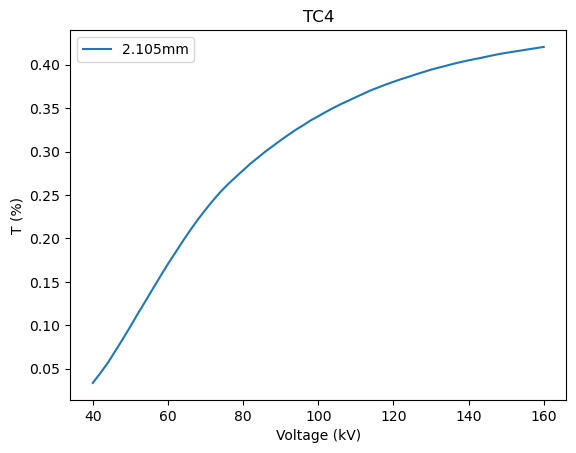

In [12]:
path_test = r'./transmission_white/display test/tc4/'
result_display(path_test, title = 'TC4', ylabel = 'T (%)', xlabel = 'Voltage (kV)')

# Define calculated functions

## Computation of mass and linear attenuation coefficient for a mixture

In [4]:
def compute_umass_Erange(element, energy):
    '''
    element: certain element name, for example 'Ti'
    energy: energy range in keV
    
    return: umass in array, unit: cm2/g
    '''
    umass = mu_elam(element, energy*1e3)
    umass_E = np.array(list(zip(energy,umass)))
    return umass_E

def compute_umass_Ecertain(element, energy):
    '''
    element: certain element name, for example 'Ti'
    energy: certain energy in keV
    
    return: umass certain, unit: cm2/g
    '''
    umass_c = mu_elam(element, energy*1e3)
    # print("For {} at E={} keV: umass ={} cm2/g".format(element, energy, umass_c))
    return umass_c

def compute_umix(sample_name, sample_weight, energy, density, database = 'xraydb'):
    '''
    sample_name: defined sample name or elemental list
    sample_weight: elemental mass fraction
    energy: certain energy in keV
    density: sample density in g/cm3 (for example, density measured by Archimedes method)
    database: database of elemental Xray mass attenuation coefficients, in default 'xraydb', choosing within 'xraydb' and 'nist'

    return: mass attenuation coefficient u_mass in cm2/g, linear attenuation coefficient u_linear in cm-1, xray energy in keV
    '''
    u_mass = 0.
    fraction_tot = round(sum(sample_weight), 2)
    if fraction_tot == 100.:
        if database == 'xraydb':
            for i in range (len(sample_name)):
                u_elem = compute_umass_Ecertain(sample_name[i], energy)
                u_mass = 0.01*sample_weight[i]*u_elem+u_mass # cm2/g
        elif database =='nist':
            for i in range (len(sample_name)):
                u_elem = getNISTdata(sample_name[i], energy)
                u_mass = 0.01 * sample_weight[i] * u_elem + u_mass  # cm2/g
        else:
            print("Please select database within xraydb and nist")
            exit()
    elif fraction_tot == 1.:
        if database == 'xraydb':
            for i in range (len(sample_name)):
                u_elem = compute_umass_Ecertain(sample_name[i],energy)
                u_mass = sample_weight[i]*u_elem+u_mass # cm2/g
        elif database == 'nist':
            for i in range (len(sample_name)):
                u_elem = getNISTdata(sample_name[i], energy)
                u_mass = sample_weight[i] * u_elem + u_mass  # cm2/g
        else:
            print("Error: Please select database in xraydb or nist")
            exit()
    else:
        print("Error: The sum of mass fraction is not 100%")
        exit()
    u_linear = density*u_mass # cm-1
    return u_mass, u_linear, energy

### Example 1: Calculate mass and linear attenuation coefficient of slm-tc4 sample at certain energy

In [5]:
# define tc4 properties which are determined by ICP and Archimedes(used in paper)
tc4 = elementlist('Ti', 'Al', 'V', 'O', 'N', 'C', 'Fe') # element name
weight_tc4 = massfraction(89.53, 6.24, 4.06, 0.11, 0.007, 0.008, 0.045) # mass fraction
# density_tc4 = 4.51 # density g/cm3 Theoretical
density_tc4 = 4.37 # density g/cm3 SLM

energy1 = 40. #kev
um, ul, ene = compute_umix(tc4, weight_tc4, energy1, density_tc4)

In [6]:
print('u_mass={} cm2/g, u_linear={} cm-1'.format(um, ul))

u_mass=2.1186848358558223 cm2/g, u_linear=9.258652732689944 cm-1


## Computation of attenuation coefficients and optimal thickness (at T=13.5%) given energy range (monochrome) 

output txt file to given path

In [7]:
def compute_MiulinearandToptimal(sample_name, sample_weight, density, energy_range, pathsave, filename, database = 'xraydb'):
    '''
    sample_name: defined sample name or elemental list
    sample_weight: elemental mass fraction
    density: sample density in g/cm3 (for example, density measured by Archimedes method)
    energy_range: a range of Xray energy in keV
    pathsave: storage path of output files
    filename: output file name
    database: database of elemental Xray mass attenuation coefficients, in default 'xraydb', choosing within 'xraydb' and 'nist'

    return: xray energy, mass attenuation coefficient u_mass in cm2/g, linear attenuation coefficient u_linear in cm-1, optimal thickness t_optiaml in mm
    output to txt files
    '''
    file = open(pathsave + filename, "w")
    print("Database is {}".format(database))
    file.write('energy (kev); u_mass (cm2/g); u_linear (cm-1); optimal_thickness (mm)' + "\n")
    for ene in energy_range:
        u_mass, u_linear, energy = compute_umix(sample_name, sample_weight, ene, density, database)
        tran = math.exp(-2)
        t_optimal = -math.log(tran)/u_linear # computation of thickness at certain transmission t = -ln(T)/u, in default cm
        t_optimal = t_optimal*10 # cm convet to mm
        file.write((str(energy) + '; ' + str(u_mass) + '; ' + str(u_linear) + '; ' + str(t_optimal)) + "\n")
    file.close()
    return

### Example 2: compare database within xraydb and nist using slm-tc4 sample

In [8]:
# define tc4 properties which are determined by ICP and Archimedes(used in paper)
tc4 = elementlist('Ti', 'Al', 'V', 'O', 'N', 'C', 'Fe') # element name
weight_tc4 = massfraction(89.53, 6.24, 4.06, 0.11, 0.007, 0.008, 0.045) # mass fraction
# density_tc4 = 4.51 # density g/cm3 Theoretical
density_tc4 = 4.37 # density g/cm3 SLM
energy_nist = [1., 1.5, 2., 3., 4., 5., 6., 8., 10., 15., 20., 30., 40., 50., 60., 80., 100., 150., 200.] # energy list of NIST database

pathex2 = r'./compare database/tc4/'
os.makedirs(pathex2, exist_ok = True)
compute_MiulinearandToptimal(tc4, weight_tc4, density_tc4, energy_nist, pathex2, 'tc4_xdb.txt', database = 'xraydb')
compute_MiulinearandToptimal(tc4, weight_tc4, density_tc4, energy_nist, pathex2, 'tc4_nist.txt', database = 'nist')

Database is xraydb
Database is nist


In [14]:
# define slm sample properties which are determined by ICP and Archimedes(used in paper)
in718 = elementlist('Ni', 'Cr', 'Nb', 'Mo', 'Ti', 'Al', 'C', 'Fe', 'Mn') # element name
weight_in718 = massfraction(53.009, 19.01, 5.09, 3.14, 0.89, 0.47, 0.028, 18.36, 0.003) # mass fraction
# density_in718 = 8.24 # density g/cm3 Theoretical
density_in718 = 8.15 # density g/cm3 SLM

alsi10mg = elementlist('Si', 'Mg', 'Fe', 'Al') # element name
weight_alsi10mg = massfraction(10.41, 0.39, 0.007, 89.193) # mass fraction
# density_alsi10mg = 2.68 # density g/cm3 Theoretical
density_alsi10mg = 2.64 # density g/cm3 SLM

ss316l = elementlist('Ni', 'Cr', 'Mo', 'C', 'Mn', 'Si', 'P', 'S', 'N', 'Fe') # element name
weight_ss316l = massfraction(10.94, 16.79, 2.49, 0.025, 0.72, 0.63, 0.023, 0.006, 0.09, 68.286) # mass fraction
# density_ss316l = 7.98 # density g/cm3 Theoretical
density_ss316l = 7.89 # density g/cm3 SLM

pathex2_in718 = r'./compare database/in718/'
os.makedirs(pathex2_in718, exist_ok = True)
pathex2_ss316l = r'./compare database/ss316l/'
os.makedirs(pathex2_ss316l, exist_ok = True)
pathex2_alsi10mg = r'./compare database/alsi10mg/'
os.makedirs(pathex2_alsi10mg, exist_ok = True)

compute_MiulinearandToptimal(in718, weight_in718, density_in718, energy_nist, pathex2_in718, 'in718_xdb.txt', database = 'xraydb')
compute_MiulinearandToptimal(in718, weight_in718, density_in718, energy_nist, pathex2_in718, 'in718_nist.txt', database = 'nist')

compute_MiulinearandToptimal(ss316l, weight_ss316l, density_ss316l, energy_nist, pathex2_ss316l, 'ss316l_xdb.txt', database = 'xraydb')
compute_MiulinearandToptimal(ss316l, weight_ss316l, density_ss316l, energy_nist, pathex2_ss316l, 'ss316l_nist.txt', database = 'nist')

compute_MiulinearandToptimal(alsi10mg, weight_alsi10mg, density_alsi10mg, energy_nist, pathex2_alsi10mg, 'alsi10mg_xdb.txt', database = 'xraydb')
compute_MiulinearandToptimal(alsi10mg, weight_alsi10mg, density_alsi10mg, energy_nist, pathex2_alsi10mg, 'alsi10mg_nist.txt', database = 'nist')

Database is xraydb
Database is nist
Database is xraydb
Database is nist
Database is xraydb
Database is nist


Text(0, 0.5, 'u_mass based on nist (cm2/g)')

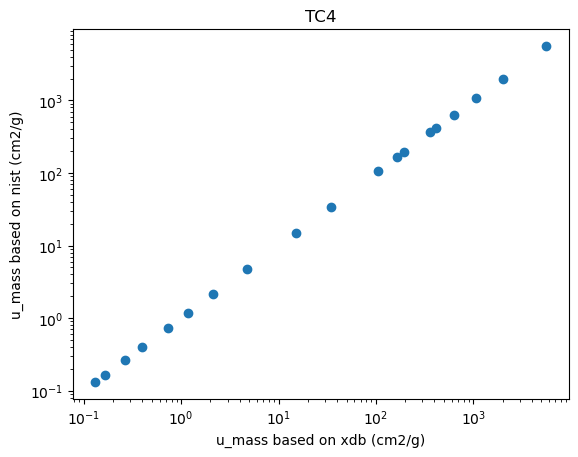

In [15]:
data_xdb = np.loadtxt(pathex2+'tc4_xdb.txt', delimiter=';', skiprows = 1, dtype = float)
data_nist = np.loadtxt(pathex2+'tc4_nist.txt', delimiter=';', skiprows = 1, dtype = float)
um_xdb = data_xdb[:,1] 
um_nist = data_nist[:,1]
plt.scatter(um_xdb, um_nist)
plt.xscale('log')
plt.yscale('log')
plt.title('TC4')
plt.xlabel('u_mass based on xdb (cm2/g)')
plt.ylabel('u_mass based on nist (cm2/g)')

### Example 3: Compute optimal thickness of slm samples at certain energy range (monochrome, database is xraydb)

In [16]:
# define slm sample properties which are determined by ICP and Archimedes(used in paper)
tc4 = elementlist('Ti', 'Al', 'V', 'O', 'N', 'C', 'Fe') # element name
weight_tc4 = massfraction(89.53, 6.24, 4.06, 0.11, 0.007, 0.008, 0.045) # mass fraction
# density_tc4 = 4.51 # density g/cm3 Theoretical
density_tc4 = 4.37 # density g/cm3 SLM

in718 = elementlist('Ni', 'Cr', 'Nb', 'Mo', 'Ti', 'Al', 'C', 'Fe', 'Mn') # element name
weight_in718 = massfraction(53.009, 19.01, 5.09, 3.14, 0.89, 0.47, 0.028, 18.36, 0.003) # mass fraction
# density_in718 = 8.24 # density g/cm3 Theoretical
density_in718 = 8.15 # density g/cm3 SLM

alsi10mg = elementlist('Si', 'Mg', 'Fe', 'Al') # element name
weight_alsi10mg = massfraction(10.41, 0.39, 0.007, 89.193) # mass fraction
# density_alsi10mg = 2.68 # density g/cm3 Theoretical
density_alsi10mg = 2.64 # density g/cm3 SLM

ss316l = elementlist('Ni', 'Cr', 'Mo', 'C', 'Mn', 'Si', 'P', 'S', 'N', 'Fe') # element name
weight_ss316l = massfraction(10.94, 16.79, 2.49, 0.025, 0.72, 0.63, 0.023, 0.006, 0.09, 68.286) # mass fraction
# density_ss316l = 7.98 # density g/cm3 Theoretical
density_ss316l = 7.89 # density g/cm3 SLM

energy_ex3 = defenergy_range(1., 160., 0.1)

pathex3= r'./optimal thickness_monochrome/'
os.makedirs(pathex3, exist_ok = True)

compute_MiulinearandToptimal(tc4, weight_tc4, density_tc4, energy_ex3, pathex3, 'tc4.txt', database = 'xraydb')
compute_MiulinearandToptimal(in718, weight_in718, density_in718, energy_ex3, pathex3, 'in718.txt', database = 'xraydb')
compute_MiulinearandToptimal(ss316l, weight_ss316l, density_ss316l, energy_ex3, pathex3, 'ss316l.txt', database = 'xraydb')
compute_MiulinearandToptimal(alsi10mg, weight_alsi10mg, density_alsi10mg, energy_ex3, pathex3, 'alsi10mg.txt', database = 'xraydb')

Database is xraydb
Database is xraydb
Database is xraydb
Database is xraydb


['tc4.txt', 'alsi10mg.txt', 'ss316l.txt', 'in718.txt']


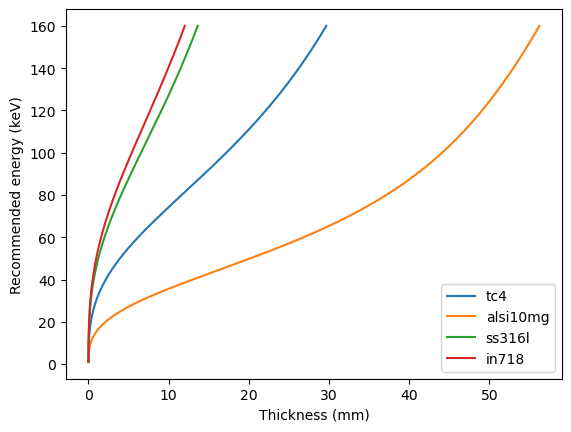

In [17]:
result_display(r'./optimal thickness_monochrome/', title = None, xlabel = 'Thickness (mm)', ylabel = 'Recommended energy (keV)', x=3, y=0)

## Computation of transmission with energy varing for given sample thickness (monochrome)

In [18]:
def compute_transmission_tcertain_mono(sample_name, sample_weight, density, energy, sample_thickness, pathsave):
    '''
    sample_name: defined sample name or elemental list
    sample_weight: elemental mass fraction
    density: sample density in g/cm3 (for example, density measured by Archimedes method)
    energy: a range of Xray energy in keV
    sample_thickness: a range of sample thickness in mm
    pathsave: storage path of output files

    return: output transmission vs energy to txt files (filename is *mm.txt)
    '''
    for thick in sample_thickness:
        filename = '{}mm.txt'.format(thick)
        file = open(pathsave + filename, 'w')
        file.write('energy (keV); transmission' + "\n")
        for ene in energy:
            u_mass, u_linear, ene = compute_umix(sample_name, sample_weight, ene, density)
            transmission = math.exp(-u_linear*0.1*thick)
            file.write((str(ene) + '; ' + str(transmission) + "\n"))
        file.close()
    return

#### Example 4: Calculate transmission of slm samples for given thickness at various xray energy

In [19]:
# define slm sample properties which are determined by ICP and Archimedes(used in paper)
tc4 = elementlist('Ti', 'Al', 'V', 'O', 'N', 'C', 'Fe') # element name
weight_tc4 = massfraction(89.53, 6.24, 4.06, 0.11, 0.007, 0.008, 0.045) # mass fraction
# density_tc4 = 4.51 # density g/cm3 Theoretical
density_tc4 = 4.37 # density g/cm3 SLM

in718 = elementlist('Ni', 'Cr', 'Nb', 'Mo', 'Ti', 'Al', 'C', 'Fe', 'Mn') # element name
weight_in718 = massfraction(53.009, 19.01, 5.09, 3.14, 0.89, 0.47, 0.028, 18.36, 0.003) # mass fraction
# density_in718 = 8.24 # density g/cm3 Theoretical
density_in718 = 8.15 # density g/cm3 SLM

alsi10mg = elementlist('Si', 'Mg', 'Fe', 'Al') # element name
weight_alsi10mg = massfraction(10.41, 0.39, 0.007, 89.193) # mass fraction
# density_alsi10mg = 2.68 # density g/cm3 Theoretical
density_alsi10mg = 2.64 # density g/cm3 SLM

ss316l = elementlist('Ni', 'Cr', 'Mo', 'C', 'Mn', 'Si', 'P', 'S', 'N', 'Fe') # element name
weight_ss316l = massfraction(10.94, 16.79, 2.49, 0.025, 0.72, 0.63, 0.023, 0.006, 0.09, 68.286) # mass fraction
# density_ss316l = 7.98 # density g/cm3 Theoretical
density_ss316l = 7.89 # density g/cm3 SLM

pathex4_tc4 = r'./transmission_monochrome/thickness certain/tc4/'
pathex4_in718 = r'./transmission_monochrome/thickness certain/in718/'
pathex4_ss316l = r'./transmission_monochrome/thickness certain/ss316l/'
pathex4_alsi10mg = r'./transmission_monochrome/thickness certain/alsi10mg/'
os.makedirs(pathex4_tc4, exist_ok = True)
os.makedirs(pathex4_in718, exist_ok = True)
os.makedirs(pathex4_ss316l, exist_ok = True)
os.makedirs(pathex4_alsi10mg, exist_ok = True)

thickness_tc4 = np.arange(1., 11., 1.)
thickness_in718 = np.arange(0.5, 6.5, 0.5)
thickness_ss316l= np.arange(0.5, 6.5, 0.5)
thickness_alsi10mg = np.arange(2., 16., 2.)
energy_ex4 = defenergy_range(1., 160., 0.1)

compute_transmission_tcertain_mono(in718, weight_in718, density_in718, energy_ex4, thickness_in718, pathex4_in718)
compute_transmission_tcertain_mono(tc4, weight_tc4, density_tc4, energy_ex4, thickness_tc4, pathex4_tc4)
compute_transmission_tcertain_mono(ss316l, weight_ss316l, density_ss316l, energy_ex4, thickness_ss316l, pathex4_ss316l)
compute_transmission_tcertain_mono(alsi10mg, weight_alsi10mg, density_alsi10mg, energy_ex4, thickness_alsi10mg, pathex4_alsi10mg)

['1.0mm.txt', '2.0mm.txt', '3.0mm.txt', '4.0mm.txt', '5.0mm.txt', '6.0mm.txt', '7.0mm.txt', '8.0mm.txt', '9.0mm.txt', '10.0mm.txt']


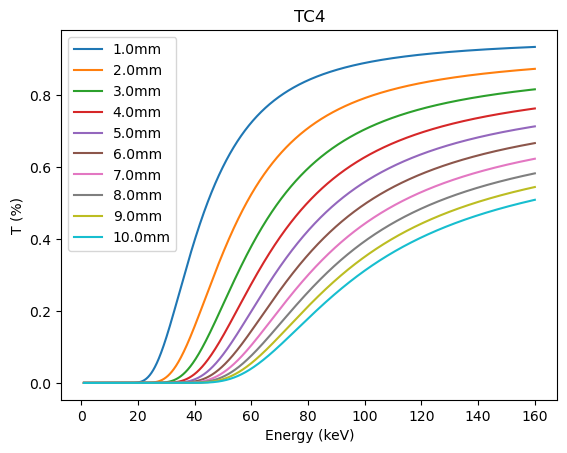

In [22]:
result_display(r'./transmission_monochrome/thickness certain/tc4/', title = 'TC4', ylabel = 'T (%)', xlabel = 'Energy (keV)')

## Computation of transmission with thickness varying for given xray energy (monochrome)

In [23]:
def compute_transmission_Ecertain_mono(sample_name, sample_weight, density, energy, sample_thickness, pathsave, filename):
    '''
    sample_name: defined sample name or elemental list
    sample_weight: elemental mass fraction
    density: sample density in g/cm3 (for example, density measured by Archimedes method)
    energy: certain Xray energy in keV
    sample_thickness: a range of sample thickness in mm
    pathsave = storage path of output files
    filename: output filename

    return: output transmission vs thickness to txt files
    '''
    file = open(pathsave+filename, 'w')
    file.write('thickness (mm);transmission'+"\n")
    for thick in sample_thickness:
        u_mass, u_linear, ene = compute_umix(sample_name, sample_weight, energy, density)
        transmission = math.exp(-u_linear*0.1*thick)
        file.write((str(thick) + '; ' + str(transmission) + "\n"))
    file.close()
    return

### Example 5: Calculate transmission of slm samples for various thickness at 40keV

In [24]:
# define slm sample properties which are determined by ICP and Archimedes(used in paper)
tc4 = elementlist('Ti', 'Al', 'V', 'O', 'N', 'C', 'Fe') # element name
weight_tc4 = massfraction(89.53, 6.24, 4.06, 0.11, 0.007, 0.008, 0.045) # mass fraction
# density_tc4 = 4.51 # density g/cm3 Theoretical
density_tc4 = 4.37 # density g/cm3 SLM

in718 = elementlist('Ni', 'Cr', 'Nb', 'Mo', 'Ti', 'Al', 'C', 'Fe', 'Mn') # element name
weight_in718 = massfraction(53.009, 19.01, 5.09, 3.14, 0.89, 0.47, 0.028, 18.36, 0.003) # mass fraction
# density_in718 = 8.24 # density g/cm3 Theoretical
density_in718 = 8.15 # density g/cm3 SLM

alsi10mg = elementlist('Si', 'Mg', 'Fe', 'Al') # element name
weight_alsi10mg = massfraction(10.41, 0.39, 0.007, 89.193) # mass fraction
# density_alsi10mg = 2.68 # density g/cm3 Theoretical
density_alsi10mg = 2.64 # density g/cm3 SLM

ss316l = elementlist('Ni', 'Cr', 'Mo', 'C', 'Mn', 'Si', 'P', 'S', 'N', 'Fe') # element name
weight_ss316l = massfraction(10.94, 16.79, 2.49, 0.025, 0.72, 0.63, 0.023, 0.006, 0.09, 68.286) # mass fraction
# density_ss316l = 7.98 # density g/cm3 Theoretical
density_ss316l = 7.89 # density g/cm3 SLM

pathex5 = r'./transmission_monochrome/energy certain/40keV/'
os.makedirs(pathex5, exist_ok = True)

energy_ex5 = defenergy_certain(40.)
thickness5_tc4 = np.arange(0.5, 6.55, 0.05)
thickness5_in718 = np.arange(0.1, 3.51, 0.01)
thickness5_ss316l = np.arange(0.1, 3.51, 0.01)
thickness5_alsi10mg = np.arange(2., 20.2, 0.2)

compute_transmission_Ecertain_mono(in718, weight_in718, density_in718, energy_ex5, thickness5_in718, pathex5, filename = 'in718.txt')
compute_transmission_Ecertain_mono(tc4, weight_tc4, density_tc4, energy_ex5, thickness5_tc4, pathex5, filename = 'tc4.txt')
compute_transmission_Ecertain_mono(ss316l, weight_ss316l, density_ss316l, energy_ex5, thickness5_ss316l, pathex5, filename = 'ss316l.txt')
compute_transmission_Ecertain_mono(alsi10mg, weight_alsi10mg, density_alsi10mg, energy_ex5, thickness5_alsi10mg, pathex5, filename = 'alsi10mg.txt')

['tc4.txt', 'alsi10mg.txt', 'ss316l.txt', 'in718.txt']


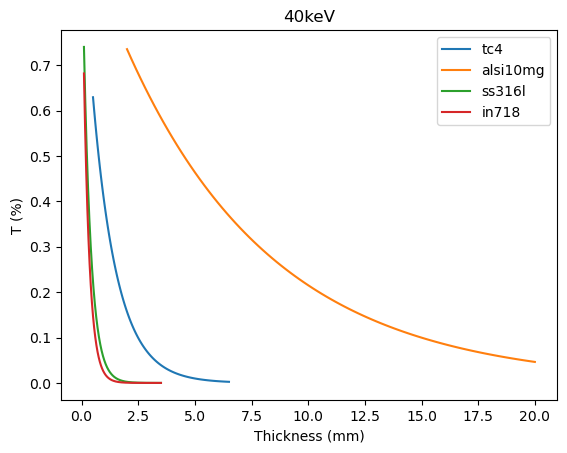

In [25]:
result_display(path = r'./transmission_monochrome/energy certain/40keV/', title = '40keV', xlabel = 'Thickness (mm)', ylabel = 'T (%)')

## Computation of transmission with thickness varying for given xray spectrum (transmitted target, input spectrum)

In [27]:
def compute_transmission_white(energy_spectra, thickness, element_list, massfraction, density):
    '''
    energy_spectra: array of normalized x-ray spectrum, assuming first col is energy and second col is weight
    thickness: input sample thickness in mm
    element_list: element list of sample
    massfraction: elemental mass fraction of sample
    density: sample density in g/cm3
    
    return: transmission
    '''
    energy = energy_spectra[:, 0]
    weight = energy_spectra[:, 1]
    transmission = 0.
    for i in range(len(energy)):
        u_mass, u_linear, ene = compute_umix(element_list, massfraction, energy[i],density, database= 'xraydb')
        transmission = weight[i]*math.exp(-u_linear*0.1*thickness)+transmission
    return transmission

def compute_transmission_Vcertain_white(path_spectra,sample_thickness, sample_name, sample_weight, density, pathsave, filetype='txt', skiprows = 1):
    '''
    path_spectra: spectra storage path
    sample_thickness: a range of sample thickness in mm
    sample_name: defined sample name or elemental list
    sample_weight: elemental mass fraction
    density: sample density in g/cm3 (for example, density measured by Archimedes method)
    pathsave = storage path of output files
    filetype: filetype of spectra file, in default 'txt' files
    skiprows: skiprows when loading spectra files， in default 1, that skip the first row (E = 0)

    return: output transmission vs thickness to txt files
    '''
    # read file name in path_spectra
    if filetype=='txt':
        path_list = glob.glob(path_spectra+'*kV.txt')
        name_list = []
        for file_path in path_list:
            file_name = file_path.split('\\')[-1]
            name_list.append(file_name)
    
        # extract voltage list and filename list in path_spectra
        voltage_list = []
        for names in name_list:
            voltage_list.append(names.replace('kV.txt','',1))
    
    elif filetype == 'xlsx':
        path_list = glob.glob(path_spectra+'*kV.xlsx')
        name_list = []
        for file_path in path_list:
            file_name = file_path.split('\\')[-1]
            name_list.append(file_name)
    
        # extract voltage list and filename list in path_spectra
        voltage_list = []
        for names in name_list:
            voltage_list.append(names.replace('kV.txt','',1))
    
    elif filetype == 'csv':
        path_list = glob.glob(path_spectra+'*kV.csv')
        name_list = []
        for file_path in path_list:
            file_name = file_path.split('\\')[-1]
            name_list.append(file_name)
    
        # extract voltage list and filename list in path_spectra
        voltage_list = []
        for names in name_list:
            voltage_list.append(names.replace('kV.txt','',1))

    # reorder voltage list and filename list
    name_list.sort(key=lambda i: int(re.findall('\d+', i)[0]))
    voltage_list.sort(key=lambda i: int(re.findall('\d+', i)[0]))  
    
    print("name list:{}".format(name_list))
    print("voltage list:{}".format(voltage_list))

    transmission = []
    
    if filetype == 'xlsx':
        for i in range(len(name_list)):
            path = path_spectra+str(name_list[i])
            voltage = voltage_list[i]
            spectra = pd.read_excel(path,skiprows = skiprows, header = None, dtype=float)
            spectra_list = spectra.values.tolist()
            arr_spectra = np.array(spectra_list)
#             print("spectrom_arr: {}".format(arr_spectra))
            ele_types = [type(ele).__name__ for ele in spectra_list]
#             print(ele_types)
            spectra_norm = Xspectra_normalization(arr_spectra)
            # print("spectrom_norm: {}".format(spectra_norm))
            filesave = open(pathsave+str(voltage)+'kV.txt','w')
            filesave.write('thickness (mm);transmission'+'\n')
            for thick in sample_thickness:
                trans = compute_transmission_white(spectra_norm, thick, sample_name, sample_weight, density)
                filesave.write((str(thick)+';'+str(trans)+'\n'))
                transmission.append(trans)
            filesave.close()
    
    elif filetype =='csv':
        for i in range(len(name_list)):
            path = path_spectra+str(name_list[i])
            voltage = voltage_list[i]
            spectra = pd.read_csv(path, delimiter=',', skiprows = skiprows,header = None, dtype=float)
            spectra_list = spectra.values.tolist()
            arr_spectra = np.array(spectra_list)
#             print("spectrom_arr: {}".format(arr_spectra))
            ele_types = [type(ele).__name__ for ele in spectra_list]
#             print(ele_types)
            spectra_norm = Xspectra_normalization(arr_spectra)
            # print("spectrom_norm: {}".format(spectra_norm))
            filesave = open(pathsave+str(voltage)+'kV.txt','w')
            filesave.write('thickness (mm);transmission'+'\n')
            for thick in sample_thickness:
                trans = compute_transmission_white(spectra_norm, thick, sample_name, sample_weight, density)
                filesave.write((str(thick)+';'+str(trans)+'\n'))
                transmission.append(trans)
            filesave.close()
    
    elif filetype =='txt':
        for i in range(len(name_list)):
            path = path_spectra+str(name_list[i])
            voltage = voltage_list[i]
            spectra = np.loadtxt(path, delimiter=';',skiprows = skiprows, dtype=float)

            list1 = spectra[:,0]
            list2 = spectra[:,1]
            spectra_zip = tuple(zip(list1, list2))
            arr_spectra = np.array(spectra_zip)
#             print("spectrom_arr: {}".format(arr_spectra))
            spectra_norm = Xspectra_normalization(arr_spectra)
#             print("spectrom_norm: {}".format(spectra_norm))
            filesave = open(pathsave+str(name_list[i]),'w')
            filesave.write('thickness (mm);transmission'+'\n')
            for thick in sample_thickness:
                trans = compute_transmission_white(spectra_norm, thick, sample_name, sample_weight, density)
                filesave.write((str(thick)+';'+str(trans)+'\n'))
                transmission.append(trans)
            filesave.close()
    return

### Example 6: Calculate transmission of slm samples for various thickness with given spectra

In [28]:
# define slm sample properties which are determined by ICP and Archimedes(used in paper)
tc4 = elementlist('Ti', 'Al', 'V', 'O', 'N', 'C', 'Fe') # element name
weight_tc4 = massfraction(89.53, 6.24, 4.06, 0.11, 0.007, 0.008, 0.045) # mass fraction
# density_tc4 = 4.51 # density g/cm3 Theoretical
density_tc4 = 4.37 # density g/cm3 SLM

in718 = elementlist('Ni', 'Cr', 'Nb', 'Mo', 'Ti', 'Al', 'C', 'Fe', 'Mn') # element name
weight_in718 = massfraction(53.009, 19.01, 5.09, 3.14, 0.89, 0.47, 0.028, 18.36, 0.003) # mass fraction
# density_in718 = 8.24 # density g/cm3 Theoretical
density_in718 = 8.15 # density g/cm3 SLM

alsi10mg = elementlist('Si', 'Mg', 'Fe', 'Al') # element name
weight_alsi10mg = massfraction(10.41, 0.39, 0.007, 89.193) # mass fraction
# density_alsi10mg = 2.68 # density g/cm3 Theoretical
density_alsi10mg = 2.64 # density g/cm3 SLM

ss316l = elementlist('Ni', 'Cr', 'Mo', 'C', 'Mn', 'Si', 'P', 'S', 'N', 'Fe') # element name
weight_ss316l = massfraction(10.94, 16.79, 2.49, 0.025, 0.72, 0.63, 0.023, 0.006, 0.09, 68.286) # mass fraction
# density_ss316l = 7.98 # density g/cm3 Theoretical
density_ss316l = 7.89 # density g/cm3 SLM

pathex6_sp = r'./spectrum data\25umW 1mmC 1.2mmSiO2\Example 6/'

pathex6_tc4 = r'./transmission_white/Example 6/tc4/'
pathex6_in718 = r'./transmission_white/Example 6/in718/'
pathex6_ss316l = r'./transmission_white/Example 6/ss316l/'
pathex6_alsi10mg = r'./transmission_white/Example 6/alsi10mg/'
os.makedirs(pathex6_tc4, exist_ok = True)
os.makedirs(pathex6_in718, exist_ok = True)
os.makedirs(pathex6_ss316l, exist_ok = True)
os.makedirs(pathex6_alsi10mg, exist_ok = True)

thickness6_tc4 = np.arange(0.5,6.05,0.05)
thickness6_in718 = np.arange(0.1,3.05,0.02)
thickness6_ss316l = np.arange(0.1,3.05,0.02)
thickness6_alsi10mg = np.arange(3.,15.1,0.2)

['60kV.txt', '80kV.txt', '100kV.txt', '120kV.txt', '150kV.txt']


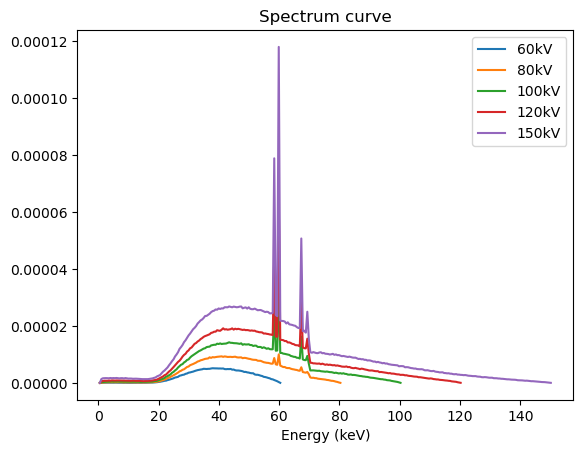

In [29]:
result_display(path = r'./spectrum data\25umW 1mmC 1.2mmSiO2\Example 6/', title = 'Spectrum curve', xlabel = 'Energy (keV)', ylabel = None)

In [30]:
import time
t1 = time.time()

compute_transmission_Vcertain_white(pathex6_sp, thickness6_tc4, tc4, weight_tc4, density_tc4, pathex6_tc4,filetype = 'txt', skiprows = 0)
compute_transmission_Vcertain_white(pathex6_sp, thickness6_in718, in718, weight_in718, density_in718, pathex6_in718,filetype = 'txt', skiprows = 0)
compute_transmission_Vcertain_white(pathex6_sp, thickness6_ss316l, ss316l, weight_ss316l, density_ss316l, pathex6_ss316l,filetype = 'txt', skiprows = 0)
compute_transmission_Vcertain_white(pathex6_sp, thickness6_alsi10mg, alsi10mg, weight_alsi10mg, density_alsi10mg, pathex6_alsi10mg,filetype = 'txt', skiprows = 0)

t2 = time.time()
print(t2-t1)

name list:['60kV.txt', '80kV.txt', '100kV.txt', '120kV.txt', '150kV.txt']
voltage list:['60', '80', '100', '120', '150']
name list:['60kV.txt', '80kV.txt', '100kV.txt', '120kV.txt', '150kV.txt']
voltage list:['60', '80', '100', '120', '150']
name list:['60kV.txt', '80kV.txt', '100kV.txt', '120kV.txt', '150kV.txt']
voltage list:['60', '80', '100', '120', '150']
name list:['60kV.txt', '80kV.txt', '100kV.txt', '120kV.txt', '150kV.txt']
voltage list:['60', '80', '100', '120', '150']
948.1846175193787


['60kV.txt', '80kV.txt', '100kV.txt', '120kV.txt', '150kV.txt']


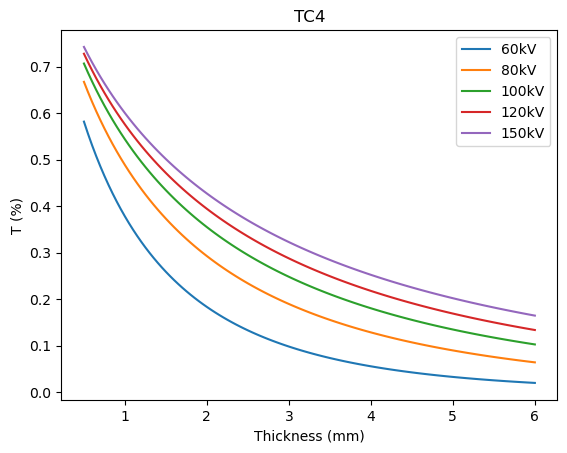

In [31]:
result_display(path = r'./transmission_white/Example 6/tc4/', title = 'TC4', xlabel = 'Thickness (mm)', ylabel = 'T (%)')

## Computation of transmission with voltage varying for given sample thickness (transmitted target, input spectrum)

In [32]:
def compute_transmission_tcertain_white(path_spectra,sample_thickness, sample_name, sample_weight, sample_density, pathsave, filetype='txt', skiprows = 1):
    '''
    path_spectra: spectra storage path
    sample_thickness: certain sample thickness in mm
    sample_name: defined sample name or elemental list
    sample_weight: elemental mass fraction
    sample_density: sample density in g/cm3 (for example, density measured by Archimedes method)
    pathsave = storage path of output files
    filetype: filetype of spectra file, in default 'txt' files
    skiprows: skiprows when loading spectra files， in default 1, that skip the first row (E = 0)
    '''
    # read file name in path_spectra
    if filetype=='txt':
        path_list = glob.glob(path_spectra+'*kV.txt')
        name_list = []
        for file_path in path_list:
            file_name = file_path.split('\\')[-1]
            name_list.append(file_name)
    
        # extract voltage list and filename list in path_spectra
        voltage_list = []
        for names in name_list:
            voltage_list.append(names.replace('kV.txt','',1))
    
    elif filetype == 'xlsx':
        path_list = glob.glob(path_spectra+'*kV.xlsx')
        name_list = []
        for file_path in path_list:
            file_name = file_path.split('\\')[-1]
            name_list.append(file_name)
    
        # extract voltage list and filename list in path_spectra
        voltage_list = []
        for names in name_list:
            voltage_list.append(names.replace('kV.txt','',1))
    
    elif filetype == 'csv':
        path_list = glob.glob(path_spectra+'*kV.csv')
        name_list = []
        for file_path in path_list:
            file_name = file_path.split('\\')[-1]
            name_list.append(file_name)
    
        # extract voltage list and filename list in path_spectra
        voltage_list = []
        for names in name_list:
            voltage_list.append(names.replace('kV.txt','',1))

    # reorder voltage list and filename list
    name_list.sort(key=lambda i: int(re.findall('\d+', i)[0]))
    voltage_list.sort(key=lambda i: int(re.findall('\d+', i)[0]))  
    
    # print("name list:{}".format(name_list))
    # print("voltage list:{}".format(voltage_list))

    transmission = []
    
    if filetype == 'xlsx':
        filesave = open(pathsave+str(sample_thickness)+'mm.txt','w')
        filesave.write('voltage (kV);transmission'+'\n')
        for i in range(len(name_list)):
            path = path_spectra+str(name_list[i])
            voltage = voltage_list[i]
            spectra = pd.read_excel(path,skiprows = skiprows, header = None, dtype=float)
            spectra_list = spectra.values.tolist()
            arr_spectra = np.array(spectra_list)
    #             print("spectrom_arr: {}".format(arr_spectra))
            ele_types = [type(ele).__name__ for ele in spectra_list]
    #             print(ele_types)
            spectra_norm = Xspectra_normalization(arr_spectra)
                # print("spectrom_norm: {}".format(spectra_norm))
            trans = compute_transmission_white(spectra_norm, sample_thickness, sample_name, sample_weight, sample_density)
            filesave.write((str(voltage)+';'+str(trans)+'\n'))
            transmission.append(trans)
        filesave.close()
    
    elif filetype =='csv':
        filesave = open(pathsave+str(sample_thickness)+'mm.txt','w')
        filesave.write('voltage (kV);transmission'+'\n')
        for i in range(len(name_list)):
            path = path_spectra+str(name_list[i])
            voltage = voltage_list[i]
            spectra = pd.read_csv(path, delimiter=',', skiprows = skiprows,header = None, dtype=float)
            spectra_list = spectra.values.tolist()
            arr_spectra = np.array(spectra_list)
    #             print("spectrom_arr: {}".format(arr_spectra))
            ele_types = [type(ele).__name__ for ele in spectra_list]
    #             print(ele_types)
            spectra_norm = Xspectra_normalization(arr_spectra)
                # print("spectrom_norm: {}".format(spectra_norm))
            trans = compute_transmission_white(spectra_norm, sample_thickness, sample_name, sample_weight, sample_density)
            filesave.write((str(voltage)+';'+str(trans)+'\n'))
            transmission.append(trans)
        filesave.close()
    
    elif filetype =='txt':
        filesave = open(pathsave+str(sample_thickness)+'mm.txt','w')
        filesave.write('voltage (kV);transmission'+'\n')
        for i in range(len(name_list)):
            path = path_spectra+str(name_list[i])
            voltage = voltage_list[i]
            spectra = np.loadtxt(path, delimiter=';',skiprows = skiprows, dtype=float)
            list1 = spectra[:,0]
            list2 = spectra[:,1]
            spectra_zip = tuple(zip(list1, list2))
            arr_spectra = np.array(spectra_zip)
    #             print("spectrom_arr: {}".format(arr_spectra))
            spectra_norm = Xspectra_normalization(arr_spectra)
    #             print("spectrom_norm: {}".format(spectra_norm))
            trans = compute_transmission_white(spectra_norm, sample_thickness, sample_name, sample_weight, sample_density)
            filesave.write((str(voltage)+';'+str(trans)+'\n'))
            transmission.append(trans)
        filesave.close()
    return


### Example 7: Calculate transmission of slm samples for various voltage with given thickness

In [33]:
# define slm sample properties which are determined by ICP and Archimedes(used in paper)
tc4 = elementlist('Ti', 'Al', 'V', 'O', 'N', 'C', 'Fe') # element name
weight_tc4 = massfraction(89.53, 6.24, 4.06, 0.11, 0.007, 0.008, 0.045) # mass fraction
# density_tc4 = 4.51 # density g/cm3 Theoretical
density_tc4 = 4.37 # density g/cm3 SLM

pathex7_sp = r'./spectrum data\25umW 1mmC 1.2mmSiO2\40-160kV/'

pathex7_tc4 = r'./transmission_white/Example 7/tc4/'
os.makedirs(pathex7_tc4, exist_ok = True)

thickness7_tc4 = 2.105 # mm

In [34]:
compute_transmission_tcertain_white(pathex7_sp,thickness7_tc4, tc4, weight_tc4, density_tc4, pathex7_tc4,filetype = 'txt', skiprows = 0)

['2.105mm.txt']


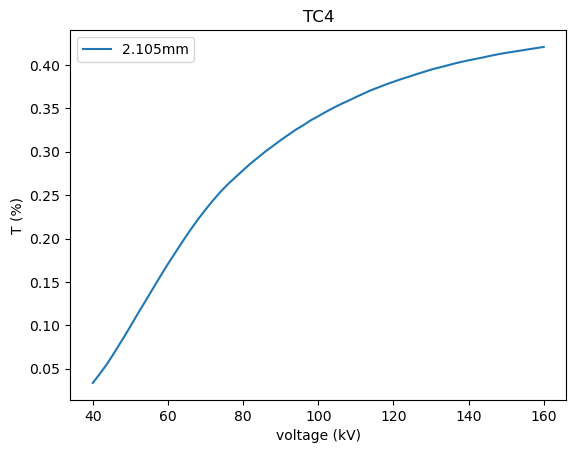

In [35]:
result_display(path=pathex7_tc4, title='TC4', xlabel = 'voltage (kV)', ylabel = 'T (%)')

## Computation of optimal voltage with given sample thickness (transmitted target, input spectrum, input archimedes and theoretical density)

In [47]:
def compute_Voptimal_white(path_spectra, sample_thickness, sample_name, sample_weight, arch_density, theo_density, filetype='txt', skiprows = 1, print_out = 'Yes'):
    '''
    path_spectra: spectra storage path
    sample_thickness: certain sample thickness in mm
    sample_name: defined sample name or elemental list
    sample_weight: elemental mass fraction
    arch_density: density measured by Archimedes method in g/cm3 (actual density of sample)
    theo_density: theoretical density of sample in g/cm3 (or density of forged sample)
    filetype: filetype of spectra file, in default 'txt' files
    skiprows: skiprows when loading spectra files， in default 1, that skip the first row (E = 0)
    print: whether print or not the optimal voltage
    '''
    # read file name in path_spectra
    if filetype=='txt':
        path_list = glob.glob(path_spectra+'*kV.txt')
        name_list = []
        for file_path in path_list:
            file_name = file_path.split('\\')[-1]
            name_list.append(file_name)
    
        # extract voltage list and filename list in path_spectra
        voltage_list = []
        for names in name_list:
            voltage_list.append(names.replace('kV.txt','',1))
    
    elif filetype == 'xlsx':
        path_list = glob.glob(path_spectra+'*kV.xlsx')
        name_list = []
        for file_path in path_list:
            file_name = file_path.split('\\')[-1]
            name_list.append(file_name)
    
        # extract voltage list and filename list in path_spectra
        voltage_list = []
        for names in name_list:
            voltage_list.append(names.replace('kV.txt','',1))
    
    elif filetype == 'csv':
        path_list = glob.glob(path_spectra+'*kV.csv')
        name_list = []
        for file_path in path_list:
            file_name = file_path.split('\\')[-1]
            name_list.append(file_name)
    
        # extract voltage list and filename list in path_spectra
        voltage_list = []
        for names in name_list:
            voltage_list.append(names.replace('kV.txt','',1))

    # reorder voltage list and filename list
    name_list.sort(key=lambda i: int(re.findall('\d+', i)[0]))
    voltage_list.sort(key=lambda i: int(re.findall('\d+', i)[0]))  
    
    # print("name list:{}".format(name_list))
    # print("voltage list:{}".format(voltage_list))

    dt = []
    t_arch = []
    t_theo = []
    voltage_arr = np.array(voltage_list)
    
    if filetype =='txt':
        for i in range(len(name_list)):
            path = path_spectra+str(name_list[i])
            voltage = voltage_list[i]
            spectra = np.loadtxt(path, delimiter=';',skiprows = skiprows, dtype=float)
            list1 = spectra[:,0]
            list2 = spectra[:,1]
            spectra_zip = tuple(zip(list1, list2))
            arr_spectra = np.array(spectra_zip)
            spectra_norm = Xspectra_normalization(arr_spectra)
            trans_arch = compute_transmission_white(spectra_norm, sample_thickness, sample_name, sample_weight, arch_density)
            trans_theo = compute_transmission_white(spectra_norm, sample_thickness, sample_name, sample_weight, theo_density)
            delta_t = abs(trans_arch-trans_theo)
            t_arch.append(trans_arch)
            t_theo.append(trans_theo)
            dt.append(delta_t)
        optimalV = voltage_list[dt.index(max(dt))]
        dt1=np.array(list(zip(voltage_list, dt)))
        t_arch1 = np.array(list(zip(voltage_list, t_arch)))
        t_theo1 = np.array(list(zip(voltage_list, t_theo)))
        if print_out == 'Yes':
            print('For {}mm given sample, the optimal voltage is {}kV'.format(sample_thickness, optimalV))

    elif filetype == 'xlsx':
        for i in range(len(name_list)):
            path = path_spectra+str(name_list[i])
            voltage = voltage_list[i]
            spectra = pd.read_excel(path,skiprows = skiprows, header = None, dtype=float)
            spectra_list = spectra.values.tolist()
            arr_spectra = np.array(spectra_list)
            ele_types = [type(ele).__name__ for ele in spectra_list]
            spectra_norm = Xspectra_normalization(arr_spectra)
            trans_arch = compute_transmission_white(spectra_norm, sample_thickness, sample_name, sample_weight, arch_density)
            trans_theo = compute_transmission_white(spectra_norm, sample_thickness, sample_name, sample_weight, theo_density)
            delta_t = abs(trans_arch-trans_theo)
            t_arch.append(trans_arch)
            t_theo.append(trans_theo)
            dt.append(delta_t)
        optimalV = voltage_list[dt.index(max(dt))]
        dt1=np.array(list(zip(voltage_list, dt)))
        t_arch1 = np.array(list(zip(voltage_list, t_arch)))
        t_theo1 = np.array(list(zip(voltage_list, t_theo)))
        if print_out == 'Yes':
            print('For {}mm given sample, the optimal voltage is {}kV'.format(sample_thickness, optimalV))

    elif filetype == 'csv':
        for i in range(len(name_list)):
            path = path_spectra+str(name_list[i])
            voltage = voltage_list[i]
            spectra = pd.read_csv(path,skiprows = skiprows, header = None, dtype=float)
            spectra_list = spectra.values.tolist()
            arr_spectra = np.array(spectra_list)
            ele_types = [type(ele).__name__ for ele in spectra_list]
            spectra_norm = Xspectra_normalization(arr_spectra)
            trans_arch = compute_transmission_white(spectra_norm, sample_thickness, sample_name, sample_weight, arch_density)
            trans_theo = compute_transmission_white(spectra_norm, sample_thickness, sample_name, sample_weight, theo_density)
            delta_t = abs(trans_arch-trans_theo)
            t_arch.append(trans_arch)
            t_theo.append(trans_theo)
            dt.append(delta_t)
        optimalV = voltage_list[dt.index(max(dt))]
        dt1=np.array(list(zip(voltage_list, dt)))
        t_arch1 = np.array(list(zip(voltage_list, t_arch)))
        t_theo1 = np.array(list(zip(voltage_list, t_theo)))
        if print_out == 'Yes':
            print('For {}mm given sample, the optimal voltage is {}kV'.format(sample_thickness, optimalV))

    return dt1, t_arch1, t_theo1, optimalV

### Example 8: Calculate the optimal voltage of SLM-TC4 with given thickness (2.105mm (CT sample using in paper)) 

In [48]:
# define slm sample properties which are determined by ICP and Archimedes(used in paper)
tc4 = elementlist('Ti', 'Al', 'V', 'O', 'N', 'C', 'Fe') # element name
weight_tc4 = massfraction(89.53, 6.24, 4.06, 0.11, 0.007, 0.008, 0.045) # mass fraction
density_tc4_theo = 4.51 # density g/cm3 Theoretical
density_tc4_arch = 4.37 # density g/cm3 SLM

path8_sp = r'./spectrum data\25umW 1mmC 1.2mmSiO2\40-160kV/'

dt, t_arch, t_theo, optimalV = compute_Voptimal_white(path8_sp, 2.105, tc4, weight_tc4, arch_density = density_tc4_arch, theo_density = density_tc4_theo)

For 2.105mm given sample, the optimal voltage is 94kV


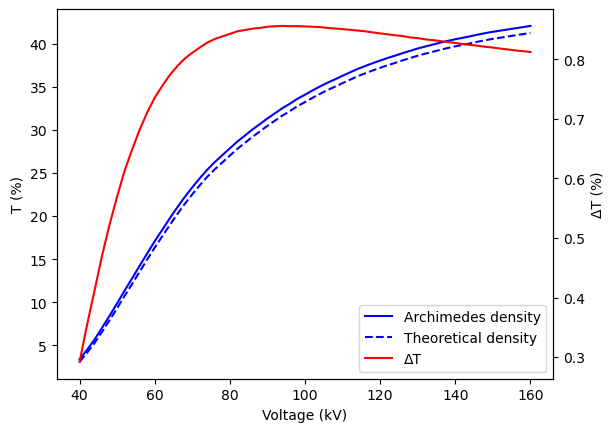

In [49]:
vol = dt[:,0].astype('float')
y_dt = dt[:,1].astype('float')
y_arch = t_arch[:,1].astype('float')
y_theo = t_theo[:,1].astype('float')

y_dt = y_dt*100
y_arch = y_arch*100
y_theo = y_theo*100

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Voltage (kV)')
ax1.set_ylabel('T (%)')
lin1 = ax1.plot(vol, y_arch, label = 'Archimedes density', color='b')
lin2 = ax1.plot(vol, y_theo, label = 'Theoretical density', color = 'b', linestyle = '--')

ax2 = ax1.twinx()
lin3 = ax2.plot(vol, y_dt, label = 'ΔT', color = 'r')
ax2.set_ylabel('ΔT (%)')

lines = lin1+lin2+lin3
labs = [label.get_label() for label in lines]
ax1.legend(lines, labs, loc='lower right')
plt.show()


In [60]:
print(y_arch)

[ 3.3708199   4.49678706  5.68888487  7.05475784  8.44783366  9.88444899
 11.36478629 12.7875925  14.24230811 15.67371268 17.08011661 18.40171625
 19.73465389 21.01006676 22.2143311  23.33791858 24.39609112 25.39054739
 26.27252085 27.07295622 27.86326075 28.64711118 29.34247577 30.04556371
 30.67941006 31.32570977 31.92975501 32.52447505 33.04593216 33.61172827
 34.08548397 34.57684015 35.04151305 35.47448233 35.86804805 36.28185745
 36.67686178 37.07192907 37.40651428 37.74142319 38.0456519  38.34841289
 38.61511379 38.91125134 39.17212188 39.44693536 39.67385855 39.89183871
 40.12344153 40.33059178 40.5193895  40.69130416 40.86672125 41.05714081
 41.22921143 41.38280627 41.51731065 41.65299433 41.79269175 41.92619751
 42.06276239]


In [62]:
pathex8 = r'./transmission_white/Example 8/'
fileex8 = open(pathex8+'TC4 2.105mm.txt', 'w')
fileex8.write('voltage (kV); t_archimedes (%); t_theoretical (%); dt (%)'+'\n')
for i in range(len(vol)):
    fileex8.write((str(vol[i])+';'+str(y_arch[i])+';'+str(y_theo[i])+';'+str(y_dt[i])+'\n'))
fileex8.close()

## Computation of optimal voltage curve with thickness varying 

In [50]:
def compute_VoptimalCurve_white(path_spectra, sample_thickness, sample_name, sample_weight, arch_density, theo_density, pathsave, filename, filetype='txt', skiprows = 1, print_out = 'Yes'):
    '''
    path_spectra: spectra storage path
    sample_thickness: certain sample thickness in mm
    sample_name: defined sample name or elemental list
    sample_weight: elemental mass fraction
    arch_density: density measured by Archimedes method in g/cm3 (actual density of sample)
    theo_density: theoretical density of sample in g/cm3 (or density of forged sample)
    pathsave: storage path of output files 
    filename: output filename
    filetype: filetype of spectra file, in default 'txt' files
    skiprows: skiprows when loading spectra files， in default 1, that skip the first row (E = 0)
    print: whether print or not the optimal voltage
    '''
    filesave = open(pathsave+filename, 'w')
    filesave.write('thickness (mm); voltage (kV)'+'\n')
    optV = []
    for thick in sample_thickness:
        dt, t_arch, t_theo, optimalV = compute_Voptimal_white(path_spectra, thick, sample_name, sample_weight, arch_density = arch_density, theo_density = theo_density, print_out = print_out)
        filesave.write((str(thick)+';'+str(optimalV)+'\n'))
        optV.append(optimalV)
    filesave.close()
    return optV

### Example 9: Calculate the optimal voltage for slm samples

In [54]:
# define slm sample properties which are determined by ICP and Archimedes(used in paper)
tc4 = elementlist('Ti', 'Al', 'V', 'O', 'N', 'C', 'Fe') # element name
weight_tc4 = massfraction(89.53, 6.24, 4.06, 0.11, 0.007, 0.008, 0.045) # mass fraction
density_tc4_theo = 4.51 # density g/cm3 Theoretical
density_tc4_arch = 4.37 # density g/cm3 SLM

in718 = elementlist('Ni', 'Cr', 'Nb', 'Mo', 'Ti', 'Al', 'C', 'Fe', 'Mn') # element name
weight_in718 = massfraction(53.009, 19.01, 5.09, 3.14, 0.89, 0.47, 0.028, 18.36, 0.003) # mass fraction
density_in718_theo = 8.24 # density g/cm3 Theoretical
density_in718_arch = 8.15 # density g/cm3 SLM

alsi10mg = elementlist('Si', 'Mg', 'Fe', 'Al') # element name
weight_alsi10mg = massfraction(10.41, 0.39, 0.007, 89.193) # mass fraction
density_alsi10mg_theo = 2.68 # density g/cm3 Theoretical
density_alsi10mg_arch = 2.64 # density g/cm3 SLM

ss316l = elementlist('Ni', 'Cr', 'Mo', 'C', 'Mn', 'Si', 'P', 'S', 'N', 'Fe') # element name
weight_ss316l = massfraction(10.94, 16.79, 2.49, 0.025, 0.72, 0.63, 0.023, 0.006, 0.09, 68.286) # mass fraction
density_ss316l_theo = 7.98 # density g/cm3 Theoretical
density_ss316l_arch = 7.89 # density g/cm3 SLM

pathex8 = r'./spectrum data\25umW 1mmC 1.2mmSiO2\40-160kV/'
pathsave8 = r'./optimal thickness_white/v1/'

# # v0
# thickness8_tc4 = np.arange(0.5,6.5,0.5)
# thickness8_in718 = np.arange(0.5,3.5,0.5)
# thickness8_ss316l = np.arange(0.5,3.5,0.5)
# thickness8_alsi10mg = np.arange(2.,17.,2.)

# v1
thickness8_tc4 = np.arange(0.5,4.5,0.25)
thickness8_in718 = np.arange(0.2,2.6,0.1)
thickness8_ss316l = np.arange(0.2,2.6,0.1)
thickness8_alsi10mg = np.arange(2.,17.,1.)

In [55]:
# compute_VoptimalCurve_white(pathex8, thickness8_tc4, tc4, weight_tc4, density_tc4_arch, density_tc4_theo, pathsave8, 'tc4.txt', print_out = None)
# compute_VoptimalCurve_white(pathex8, thickness8_in718, in718, weight_in718, density_in718_arch, density_in718_theo, pathsave8, 'in718.txt', print_out = None)
# compute_VoptimalCurve_white(pathex8, thickness8_ss316l, ss316l, weight_ss316l, density_ss316l_arch, density_ss316l_theo, pathsave8, 'ss316l.txt', print_out = None)
compute_VoptimalCurve_white(pathex8, thickness8_alsi10mg, alsi10mg, weight_alsi10mg, density_alsi10mg_arch, density_alsi10mg_theo, pathsave8, 'alsi10mg.txt', print_out = None)

['40',
 '40',
 '44',
 '50',
 '58',
 '68',
 '82',
 '90',
 '104',
 '116',
 '130',
 '146',
 '150',
 '160',
 '160']

['tc4.txt', 'alsi10mg.txt', 'ss316l.txt', 'in718.txt']


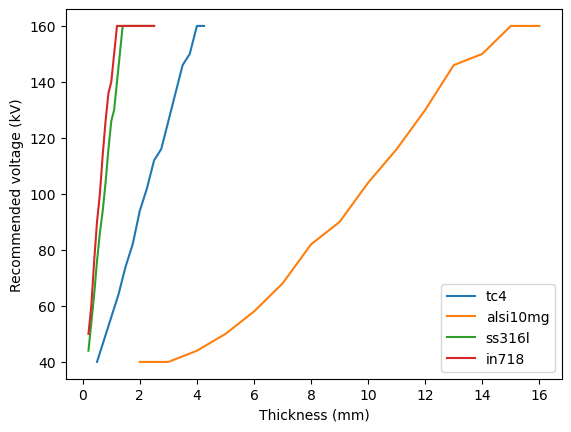

In [56]:
result_display(path=pathsave8, title=None, xlabel = 'Thickness (mm)', ylabel = 'Recommended voltage (kV)')